**Predicting the Classification of Pulsar Stars**
==========

Introduction
==

Background:
--
Pulsars are a unique type of rotating Neutron star. Pulsars emit beams of radiation when they are rotating, and emission beams can be observed on earth and be detected in a pattern of broadband radio admission. Large radio telescopes are used to collect periodic radio signals from Pulsar during their periodic repeat rotations. Any signal detected from a potential pulsar is a “candidate”. Any potential pulsar that indeedly emits the candidate would be real and classified as a “positive example”.  The rest which does not actually emit the candidate would be spurious (the signals might be emitted by radio frequency interference or noise rather than a real pulsar) and classified as a “negative example”. 

There are two ways to measure the potential signals: integrated profile and DM-SNR curve. Each provides the mean, the standard deviation, the skewness and the excess of kurtosis.

Question:
--
When given a new pulsar candidate, would the candidate describe a real pulsar or a spurious pulsar?

In [1]:
# Loading libraries
library(tidyverse)
library(RColorBrewer)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Dataset:
--------
The data set we will be using is called "Sonar Data" (doi: 10.24432/C5T01Q).  


Here is a short description of what each variable represents:
* mean_ip: the mean of the integrated profile
* sd_ip: standard deviation of the integrated profile
* kuritosis_ip : excess kurtosis of the integrated profile.
* skew_ip: skewness of the integrated profile.
* mean_dmsnr: mean of DM-SMR curve
* sd_dmsmr: standard deviation of the DM-SMR curve
* kurtosis_dmsnr: excess kurtosis of the DM-SNR curve
* skew_dmsnr: skewness of the DM-SNR curve 


In [2]:
# Reading, renaming and mutating to factor format (pulsar), tidying

star_data <- read_csv("https://raw.githubusercontent.com/luigivicencio/dsci100-003-008/main/HTRU_2.csv", col_names = FALSE) |>
    rename("mean_ip" = X1, "sd_ip" = X2, "kurtosis_ip" = X3, 
           "skew_ip" = X4, "mean_dmsnr" = X5, "sd_dmsnr" = X6, 
           "kurtosis_dmsnr" = X7, "skew_dmsnr" = X8, "pulsar" = X9)|>
    mutate(pulsar = as_factor(pulsar)) |>
    mutate(pulsar = fct_recode(pulsar,"No" = "0", "Yes" = "1"))


star_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip   sd_ip    kurtosis_ip  skew_ip     mean_dmsnr  sd_dmsnr 
1     140.56250 55.68378 -0.234571412 -0.69964840  3.1998328  19.110426
2     102.50781 58.88243  0.465318154 -0.51508791  1.6772575  14.860146
3     103.01562 39.34165  0.323328365  1.05116443  3.1212375  21.744669
4     136.75000 57.17845 -0.068414638 -0.63623837  3.6429766  20.959280
5      88.72656 40.67223  0.600866079  1.12349169  1.1789298  11.468720
6      93.57031 46.69811  0.531904850  0.41672112  1.6362876  14.545074
7     119.48438 48.76506  0.031460220 -0.11216757  0.9991639   9.279612
8     130.38281 39.84406 -0.158322759  0.38954045  1.2207358  14.378941
9     107.25000 52.62708  0.452688025  0.17034738  2.3319398  14.486853
10    107.25781 39.49649  0.465881961  1.16287712  4.0794314  24.980418
11    142.07812 45.28807 -0.320328426  0.28395251  5.3762542  29.009897
12    133.25781 44.05824 -0.081059862  0.11536151  1.6321070  12.007806
13    134.96094 49.55433 -0.135303833 -0.08046960 10.6964883  41.342044
14    117.94531 45.50658  0.325437564  0.66145946  2.8361204  23.118350
15    138.17969 51.52448 -0.031852329  0.04679717  6.3302676  31.576347
16    114.36719 51.94572 -0.094498904 -0.28798409  2.7382943  17.191891
17    109.64062 49.01765  0.137635830 -0.25669978  1.5083612  12.072901
18    100.85156 51.74352  0.393836792 -0.01124074  2.8411371  21.635778
19    136.09375 51.69100 -0.045908926 -0.27181639  9.3428094  38.096400
20     99.36719 41.57220  1.547196967  4.15410604 27.5551839  61.719016
21    100.89062 51.89039  0.627486528 -0.02649780  3.8837793  23.045267
22    105.44531 41.13997  0.142653801  0.32041968  3.5518395  20.755017
23     95.86719 42.05992  0.326386917  0.80350179  1.8327759  12.248969
24    117.36719 53.90861  0.257953441 -0.40504908  6.0183946  24.766123
25    106.64844 56.36718  0.378355072 -0.26637161  2.4364549  18.405371
26    112.71875 50.30127  0.279390953 -0.12901071  8.2817726  37.810012
27    130.85156 52.43286  0.142596727  0.01888544  2.6463211  15.654436
28    119.43750 52.87482 -0.002549267 -0.46036029  2.3653846  16.498032
29    123.21094 51.07801  0.179376819 -0.17728516  2.1070234  16.921773
30    102.61719 49.69235  0.230438984  0.19332537  1.4891304  16.004411
⋮     ⋮         ⋮        ⋮            ⋮           ⋮           ⋮        
17869  96.85938 49.82277  0.276811333 -0.33182398   1.7441472 14.764022
17870 137.37500 50.76278  0.085075173 -0.09267941   7.5610368 33.471080
17871 110.76562 55.34219  0.066099851 -0.50041490  14.3795987 45.320742
17872 119.00781 52.09104  0.215293531 -0.02022867   2.0125418 18.754594
17873 139.89844 44.28103 -0.044618449  0.10084109   1.1396321 11.196096
17874  89.45312 35.84883  0.731655618  3.10147356   1.4506689 14.204964
17875 126.55469 54.27589  0.207825362 -0.19168640   2.2943144 17.429850
17876 133.14062 43.70618 -0.012686084  0.23239435   2.0919732 13.489370
17877 111.76562 52.94359  0.671723986  0.38359393 149.8436455 97.926948
17878 118.29688 49.93282  0.144400986 -0.26927317   1.0418060 10.199265
17879  90.14844 40.78604  0.457138562  0.88551621   5.3545150 29.759511
17880 107.66406 44.46246  0.296045688  0.22776530   6.2909699 33.512873
17881 105.49219 43.50072  0.154180228  0.40811660   2.3160535 19.098507
17882 130.50000 46.14955  0.084445004 -0.10735478   1.5292642 11.757086
17883 131.00000 55.93579 -0.023598123 -0.53665128   1.1596990 10.856794
17884  84.42188 41.77556  0.757467101  1.10707476   1.3361204 12.026757
17885 106.87500 47.57133  0.199440015  0.28496422   3.0794314 20.984455
17886 133.82031 43.47816  0.136691092  0.35312123   0.9824415  9.486068
17887 127.07031 47.66356  0.006552426 -0.12363370   0.8536789 11.197206
17888 121.37500 53.24516  0.103772205 -0.36511875   1.0953177 12.239976
17889  98.72656 50.40782  0.565123614  0.24523085   0.5702341  9.011285
17890 126.62500 55.72183  0.002946216 -0.30321814   0.5342809  8.588882
17891 143.67188 45.30265 -0.045768538  0.35364267   5.1739130 26.462345
17892 118.48438 50.60848 -0.029058829 -0.02749

In [3]:
#Splitting the dataset into training and testing subgroups (where 75% of the data will be used as the training set)

star_split <- initial_split(star_data, prop = 0.75, strata = pulsar)  
star_train <- training(star_split)   
star_test <- testing(star_split)


In [4]:
#Creating a recipe, scaling, centering, and baking

star_recipe <- recipe(pulsar ~ ., data = star_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()


scaled_star <- bake(star_recipe, star_train)
scaled_star

mean_ip     sd_ip       kurtosis_ip  skew_ip      mean_dmsnr sd_dmsnr    
1      1.14775073  1.33611327 -0.667981232 -0.401675919 -0.3187090 -0.37015571 
2     -0.32910350  1.80225220 -0.015800338 -0.372000494 -0.3703659 -0.58912976 
3     -0.30939594 -1.04542561 -0.148111251 -0.120163252 -0.3213755 -0.23443979 
4     -0.86393636 -0.85152078  0.110507827 -0.108533773 -0.3872729 -0.76385571 
5     -0.67595656  0.02663185  0.046247409 -0.222175201 -0.3717559 -0.60536221 
6      0.75268995 -0.97220996 -0.596930145 -0.226545573 -0.3858545 -0.61392137 
7      0.27000632 -0.14701073 -0.146145828 -0.182823797 -0.3310488 -0.16366788 
8      1.05527679  0.72997871 -0.479080698 -0.281655161 -0.2125016  0.27208732 
9      0.13114382  0.79136485 -0.537456907 -0.335484538 -0.3343678 -0.46899847 
10    -0.05228808  0.36465820 -0.321145869 -0.330454343 -0.3760961 -0.73272832 
11     0.97432420  0.75424583 -0.492179113 -0.332884940 -0.1102941  0.60799982 
12    -0.45098718 -0.72036719  0.992331124  0.378757796  0.5076035  1.82503476 
13    -0.39186450  0.78330291  0.135313666 -0.293440237 -0.2955045 -0.16743310 
14     0.24757002  1.07741796 -0.209029828 -0.354307383 -0.2230826 -0.07877473 
15    -0.16841109  1.43570514 -0.096835495 -0.332009474 -0.3446084 -0.40648011 
16     0.06717005  0.55171983 -0.189053626 -0.309923257 -0.1462922  0.59324518 
17     0.77088154  0.86235602 -0.316523137 -0.286143079 -0.3374882 -0.54820800 
18     0.32791623  0.92676255 -0.451775109 -0.363200856 -0.3470196 -0.50474602 
19    -0.32485880  0.46298245 -0.234668735 -0.258094936 -0.3767486 -0.53017729 
20    -0.42976365 -0.37829578 -0.006099623 -0.163524734 -0.4062506 -0.86832487 
21     0.67355651  0.82435682 -0.495320768 -0.322665242 -0.3535157 -0.68527613 
22     0.39370916  0.16281546 -0.284129250 -0.285173088 -0.3542816 -0.29586343 
23    -0.33607695  0.35922981 -0.155192217 -0.321688658 -0.3628486 -0.64173702 
24    -0.11444269 -1.69121450 -0.150135011  0.003719915 -0.2949655 -0.13256519 
25    -0.12080975 -1.33848719  0.012794485 -0.050918939 -0.3874431 -0.73561281 
26     1.06619175  0.35001430 -0.486292709 -0.317517734 -0.3443814 -0.41122323 
27     0.20239423  0.12102818 -0.251900358 -0.292745610 -0.3049224 -0.37867898 
28     0.37127286 -0.14069651 -0.185761414 -0.221662668 -0.3811739 -0.68089245 
29     0.42281571  0.95122469 -0.262547590 -0.334557577 -0.3554731 -0.50047789 
30     0.55197603  0.67907723 -0.319081430 -0.351202160 -0.3883224 -0.71515433 
⋮     ⋮           ⋮           ⋮            ⋮            ⋮          ⋮           
13394  0.9806913  -0.91799688 -0.36057505  -0.22661484  -0.3574588 -0.457962277
13395 -0.3767048  -1.64005672 -0.02120649   0.06228505  -0.3843510 -0.754573715
13396  0.1629791   1.31627676 -0.32613125  -0.35145701  -0.2793918  0.084751856
13397  1.0064627   0.67783032 -0.42683988  -0.32045055  -0.3915847 -0.816648067
13398  0.8027168   0.54123671 -0.36123101  -0.36452325  -0.4085200 -0.831781646
13399 -0.5483122   0.48198792 -0.19145740  -0.34253354  -0.3680965 -0.594082042
13400  1.0240479   0.61897500 -0.37012368  -0.30408156  -0.1707449  0.369703777
13401  0.3112406   0.81254306 -0.24878178  -0.29243223  -0.3589906 -0.388488158
13402  1.1219793  -0.32560909 -0.49097660  -0.27296545  -0.3886061 -0.777901224
13403 -0.8357394  -1.55443454  0.23238197   0.20950534  -0.3780535 -0.622884640
13404  0.6041253   1.13094085 -0.25574088  -0.32000086  -0.3494308 -0.456738844
13405  0.2836500   0.49802611 -0.31484187  -0.33247602  -0.3919251 -0.829257882
13406 -0.8087552  -0.83493397 -0.02342236  -0.14679778  -0.2456063  0.178484125
13407 -0.1289960  -0.29916954 -0.17353418  -0.25255735  -0.2138349  0.371856976
13408  0.7572378  -0.05330986 -0.37071089  -0.30644121  -0.3753869 -0.748999086
13409  0.7766422   1.37283824 -0.47138915  -0.37546766  -0.3879253 -0.795382043
13410 -1.0309958  -0.69073253  0.25643398  -0.11117345  -0.3819398 -0.735105690
13411 -0.1596185   0.15388539 -0.26355463  -0.24336035  -0.3227939 -0.273605905
13412 

In [5]:
#Computing summary statistics for the training data set
star_table <- group_by(scaled_star, pulsar) |>
    summarize(count = n(),
             missing_values = sum(is.na(scaled_star)), # check that
             mean_mean_ip = mean(mean_ip), # check that
             mean_sd_ip = mean(sd_ip),
             mean_skew_ip = mean(skew_ip),
             mean_kurtosis_ip = mean(kurtosis_ip),
             mean_mean_dmsnr = mean(mean_dmsnr),
             mean_sd_dmsnr = mean(sd_dmsnr),
             mean_skew_dmsnr = mean(skew_dmsnr),
             mean_kurtosis_dmsnr = mean(kurtosis_dmsnr))

star_table

pulsar count missing_values mean_mean_ip mean_sd_ip mean_skew_ip
1 No     12210 0               0.2134209    0.1155052 -0.2264958  
2 Yes     1213 0              -2.1482841   -1.1626700  2.2798959  
  mean_kurtosis_ip mean_mean_dmsnr mean_sd_dmsnr mean_skew_dmsnr
1 -0.251061        -0.1255644      -0.1536852     0.08060191    
2  2.527168         1.2639255       1.5469874    -0.81133501    
  mean_kurtosis_dmsnr
1  0.1222123         
2 -1.2301832

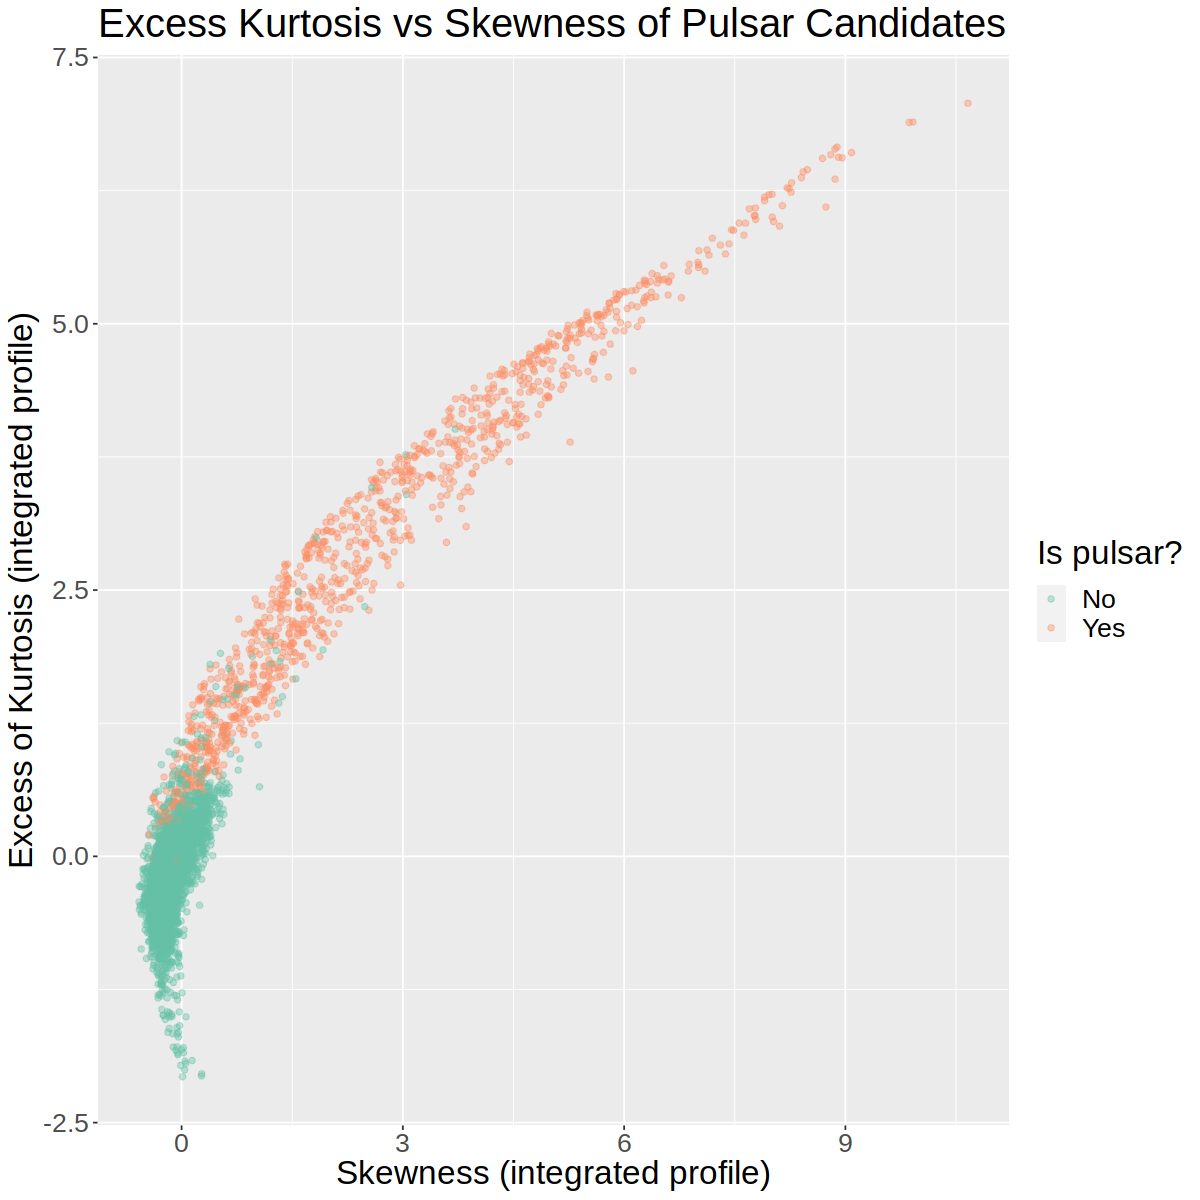

In [6]:
#Creating an initial plot to visualize the data

options(repr.plot.width = 10, repr.plot.height = 10)

star_plot_skew <- ggplot (scaled_star, aes(x = skew_ip, y = kurtosis_ip, color = pulsar)) +
                geom_point(alpha = 0.4) +
                labs(y = "Excess of Kurtosis (integrated profile)", x = "Skewness (integrated profile)", color = "Is pulsar?") + 
                ggtitle("Excess Kurtosis vs Skewness of Pulsar Candidates") +
                theme(text = element_text(size = 20)) + 
                scale_color_brewer(palette = "Set2")


star_plot_skew

Method:
--

**Columns to be Used:**
Predictors are going to be the mean of the integrated profile, skewness of the integrated profile and excess kurtosis of the integrated profile. We have two options of ways of measuring (integrated profile and DM-SNR curve), we choose to only use integrated profile. Then we are not using the standard deviation (SD), because the difference between average of pulsar’s SD and average of not pulsar’s SD is not so significant. That is why we are just choosing mean, skewness and kurtosis.

Based on those columns, the class that we want to predict is pulsar (yes: it is pulsar, no: it is not pulsar).

**Ways to Visualize Results:**
Scatterplot between two variables (for instance, kurtosis and skewness, skewness and mean, and mean and kurtosis) to see the trend in the plot and then colouring the pulsar variable: if it is pulsr or not. This will help easy visualize and see the difference.



Expected Outcomes and Significance:
--

1. **What do you expect to find?:**
Each pulsar produces a slightly different emission pattern, which varies based on the integrated profile and DM-SNR curve. Thus a  potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. In the data frame, the candidate is a pulsar or not a pulsar.
We believe that a pulsar star tends to have a lower mean, higher skewness and kurtosis (according to the summary table). A spurious pulsar star should have higher mean, and lower skewness and kurtosis.

2. **What impact could such findings have?**
We can easily figure out if the new observation is a pulsar or not a pulsar based on the early experiences and other observation’s data. While doing the work, the function can help to make the data more readable and visible. Thus, we are going to help astronomers to predict if it is a pulsar or not pulsar star through a data science analysis.

3. **What future questions could this lead to?**
Finding the category of the new observation based on 3 predictors (skewness, kurtosis and mean), what is the best K value for the nearest neighbor model?